In [1]:
import pandas as pd
import sys
sys.path.append('code/')
from config.library_graph_definition import nodes, edges
from LicenseCompatibilityMatrix import LicenseCompatibilityMatrix

platforms = ['NPM','Rubygems','Packagist']
cm = LicenseCompatibilityMatrix(nodes, edges)

# Load dependencies and compute compatibility

In [2]:
deps = pd.read_csv('./data/dependencies_ilyas.csv.gz')
deps = deps.query('kind == "runtime"') # Focus only on runtime dependencies
deps = deps[deps.columns.difference(['kind'])]
# def determine_compatible(df_row):
#     return cm.is_compatible(df_row['dep_licenses'], df_row['licenses'])
# deps['compatible'] = deps.apply(determine_compatible, axis=1)

tmp = deps.groupby('platform').name.count()
amount_of_npm_deps = tmp.NPM
amount_of_packagist_deps = tmp.Packagist
amount_of_rubygems_deps = tmp.Rubygems
total_amount_of_deps = len(deps)
print(f'Total ampunt of dependencies: {total_amount_of_deps}')
print(f'Amount of NPM dependencies: {amount_of_npm_deps} ({round(amount_of_npm_deps/total_amount_of_deps*100, 2)}%)')
print(f'Amount of Packagist dependencies: {amount_of_packagist_deps} ({round(amount_of_packagist_deps/total_amount_of_deps*100, 2)}%)')
print(f'Amount of Rubygems dependencies: {amount_of_rubygems_deps} ({round(amount_of_rubygems_deps/total_amount_of_deps*100, 2)}%)')

deps.sample()

Total ampunt of dependencies: 5501013
Amount of NPM dependencies: 4765730 (86.63%)
Amount of Packagist dependencies: 462305 (8.4%)
Amount of Rubygems dependencies: 272978 (4.96%)


,dep_licenses,dependency,licenses,name,platform
12050024,MIT,@platform/libs,MIT,@platform/cell.http,NPM


In [3]:
total_dependencies = len(deps)
total_unknown_compatibility = len(deps.query('compatible == "Unknown"'))
total_compatible = len(deps.query('compatible == True'))
total_incompatible = len(deps.query('compatible == False'))
print(f'Could not determine compatibility for {total_unknown_compatibility} or {round(total_unknown_compatibility/total_dependencies*100, 2)}% of dependencies')
print(f'{total_compatible} or {round(total_compatible/total_dependencies*100, 2)}% of dependencies are compatible')
print(f'{total_incompatible} or {round(total_incompatible/total_dependencies*100, 2)}% of dependencies are not compatible')


UndefinedVariableError: name 'compatible' is not defined

# Load packages

In [3]:
packages = pd.read_csv('./data/packages_ilyas.csv.gz')
packages = packages[packages.columns.difference(['dependent_projects', 'dependent_repos'])]
tmp = packages.groupby('platform').name.count()
amount_of_npm_packages = tmp.NPM
amount_of_packagist_packages = tmp.Packagist
amount_of_rubygems_packages = tmp.Rubygems
total_amount_of_packages = amount_of_npm_packages + amount_of_packagist_packages + amount_of_rubygems_packages
print(f'Total ampunt of packages: {total_amount_of_packages}')
print(f'Amount of NPM packages: {amount_of_npm_packages} ({round(amount_of_npm_packages/total_amount_of_packages*100, 2)}%)')
print(f'Amount of Packagist packages: {amount_of_packagist_packages} ({round(amount_of_packagist_packages/total_amount_of_packages*100, 2)}%)')
print(f'Amount of Rubygems packages: {amount_of_rubygems_packages} ({round(amount_of_rubygems_packages/total_amount_of_packages*100, 2)}%)')
packages.sample()

Total ampunt of packages: 1643480
Amount of NPM packages: 1273565 (77.49%)
Amount of Packagist packages: 208461 (12.68%)
Amount of Rubygems packages: 161454 (9.82%)


,first_release_date,licenses,name,platform
680130,2017-03-20 13:24:12 UTC,ISC,kaizen-controller,NPM


# Join packages and dependencies

In [ ]:
packages_with_deps = packages.set_index(['platform', 'name']).join(how='right', other=deps[deps.columns.difference(['licenses'])].set_index(['platform', 'name', 'dependency']))
packages_with_deps.sample()

In [4]:
curr_level = 1
curr_level_df = packages[packages.columns.difference(['licenses', 'first_release_date'])].merge(right=deps, on=['platform', 'name'])

def next_level():
    global curr_level, curr_level_df
    curr_level += 1
    curr_level_df = curr_level_df.merge(right=deps, left_on=['dependency', 'platform'], right_on=['name', 'platform'])[['name_x', 'platform', 'licenses_x', 'dependency_y', 'dep_licenses_y']]
    curr_level_df = curr_level_df.rename(columns={"name_x": "name", "licenses_x": "licenses", "dependency_y": "dependency", "dep_licenses_y": "dep_licenses"})

In [4]:
level1 = packages[packages.columns.difference(['licenses', 'first_release_date'])].merge(right=deps, on=['platform', 'name'])
level1

,name,platform,dep_licenses,dependency,licenses
0,01,NPM,MIT,commander,Unlicense
1,0815,NPM,MIT,mocha,Unlicense
2,0815,NPM,ISC,glob,Unlicense
3,0815,NPM,MIT,express,Unlicense
4,0815,NPM,MIT,async,Unlicense
...,...,...,...,...,...
5501008,dropdown-act,NPM,Other,@progress/kendo-react-common,Unlicense
5501009,dropdown-act,NPM,MIT,@types/lodash.throttle,Unlicense
5501010,dropdown-act,NPM,Apache-2.0,@progress/kendo-theme-default,Unlicense
5501011,dropdown-act,NPM,Apache-2.0,@progress/kendo-theme-bootstrap,Unlicense


In [5]:
level2 = level1.merge(right=deps, left_on=['dependency', 'platform'], right_on=['name', 'platform'])[['name_x', 'platform', 'licenses_x', 'dependency_y', 'dep_licenses_y']].rename(columns={"name_x": "name", "licenses_x": "licenses", "dependency_y": "dependency", "dep_licenses_y": "dep_licenses"})
level2

,name,platform,licenses,dependency,dep_licenses
0,01,NPM,Unlicense,keypress,MIT
1,01,NPM,Unlicense,graceful-readlink,MIT
2,0815,NPM,Unlicense,keypress,MIT
3,0815,NPM,Unlicense,graceful-readlink,MIT
4,102,NPM,Unlicense,keypress,MIT
...,...,...,...,...,...
39934567,@livy/line-formatter,NPM,MIT,luxon,MIT
39934568,@livy/line-formatter,NPM,MIT,@livy/contracts,MIT
39934569,@livy/logger,NPM,MIT,luxon,MIT
39934570,@livy/logger,NPM,MIT,@livy/contracts,MIT


In [6]:
level3 = level2.merge(right=deps, left_on=['dependency', 'platform'], right_on=['name', 'platform'])[['name_x', 'platform', 'licenses_x', 'dependency_y', 'dep_licenses_y']].rename(columns={"name_x": "name", "licenses_x": "licenses", "dependency_y": "dependency", "dep_licenses_y": "dep_licenses"})
level3

MemoryError: Unable to allocate 11.0 GiB for an array with shape (9, 163484588) and data type object

In [7]:
level3

NameError: name 'level3' is not defined

In [6]:
next_level()
curr_level_df

,name,platform,licenses,dependency,dep_licenses
0,01,NPM,Unlicense,keypress,MIT
1,01,NPM,Unlicense,graceful-readlink,MIT
2,0815,NPM,Unlicense,keypress,MIT
3,0815,NPM,Unlicense,graceful-readlink,MIT
4,102,NPM,Unlicense,keypress,MIT
...,...,...,...,...,...
39934567,@livy/line-formatter,NPM,MIT,luxon,MIT
39934568,@livy/line-formatter,NPM,MIT,@livy/contracts,MIT
39934569,@livy/logger,NPM,MIT,luxon,MIT
39934570,@livy/logger,NPM,MIT,@livy/contracts,MIT


In [7]:
next_level()
curr_level_df

MemoryError: Unable to allocate 11.0 GiB for an array with shape (9, 163484588) and data type object

In [8]:
curr_level_df.memory_usage()

Index           319476576
name            319476576
platform        319476576
licenses        319476576
dependency      319476576
dep_licenses    319476576
level           319476576
dtype: int64

In [29]:
level2 = level1.merge(right=deps, left_on=['dependency', 'platform'], right_on=['name', 'platform'])[['name_x', 'platform', 'licenses_x', 'dependency_y', 'dep_licenses_y']]
level2.rename(columns={"name_x": "name", "licenses_x": "licenses", "dependency_y": "dependency", "dep_licenses_y": "dep_licenses"})

,name,platform,licenses,dependency,dep_licenses
0,01,NPM,Unlicense,keypress,MIT
1,01,NPM,Unlicense,graceful-readlink,MIT
2,0815,NPM,Unlicense,keypress,MIT
3,0815,NPM,Unlicense,graceful-readlink,MIT
4,102,NPM,Unlicense,keypress,MIT
...,...,...,...,...,...
39934567,@livy/line-formatter,NPM,MIT,luxon,MIT
39934568,@livy/line-formatter,NPM,MIT,@livy/contracts,MIT
39934569,@livy/logger,NPM,MIT,luxon,MIT
39934570,@livy/logger,NPM,MIT,@livy/contracts,MIT


# Add direct dependency count to packages

In [9]:
direct_deps_count = (packages_with_deps
                     .groupby(['platform', 'name'])
                     .size()
                     .reset_index()
                     .rename(columns={0:'direct_dependencies'})
                     .sort_values(by='direct_dependencies', ascending=False))

packages = packages.join(other=direct_deps_count.set_index(['platform', 'name']), on=['platform', 'name']).fillna(0)
packages = packages.astype({"direct_dependencies": int})
packages.sample()

,first_release_date,licenses,name,platform,direct_dependencies
536352,2016-08-24 13:22:40 UTC,MIT,markdom/handler,Packagist,6


In [10]:
packages.query('direct_dependencies > 10')

,first_release_date,licenses,name,platform,direct_dependencies
7,2013-01-27 00:30:54 UTC,Unlicense,0815,NPM,15
11,2014-08-11 15:16:37 UTC,Apache-2.0,1-1-help-desk-system,NPM,18
18,2013-10-15 20:11:28 UTC,Unlicense,10er10,NPM,11
48,2012-08-10 06:44:10 UTC,MIT,2,NPM,15
62,2014-02-05 14:19:41 UTC,Apache-2.0,28,NPM,18
...,...,...,...,...,...
1643311,2020-01-12 19:16:14 UTC,Unlicense,@clutch-marketplace/element,NPM,11
1643316,2020-01-12 19:23:41 UTC,MIT,@fullstackio/live-server,NPM,13
1643342,2020-01-12 20:14:38 UTC,LGPL-3.0,agro-components-react,NPM,13
1643389,2020-01-12 21:51:05 UTC,ISC,discord-dynamic-music-bot-addon,NPM,15


# Visualize the evolution of licenses in each ecosystem

In [11]:
packages['created'] = packages['first_release_date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
packages['created'] = pd.to_datetime(packages['created'])

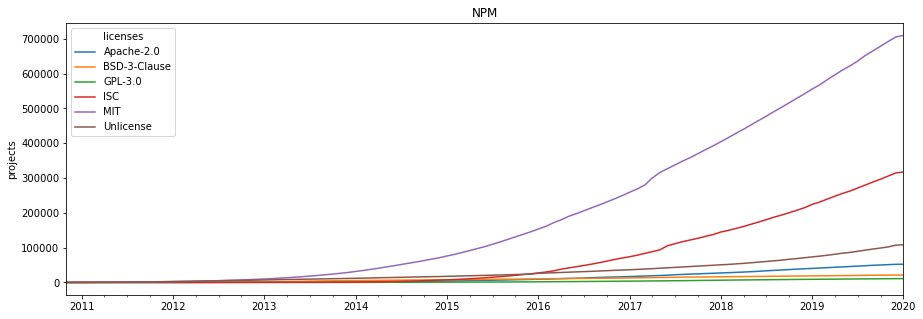

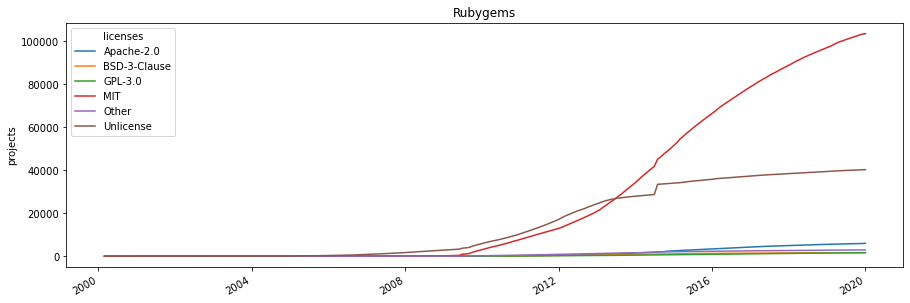

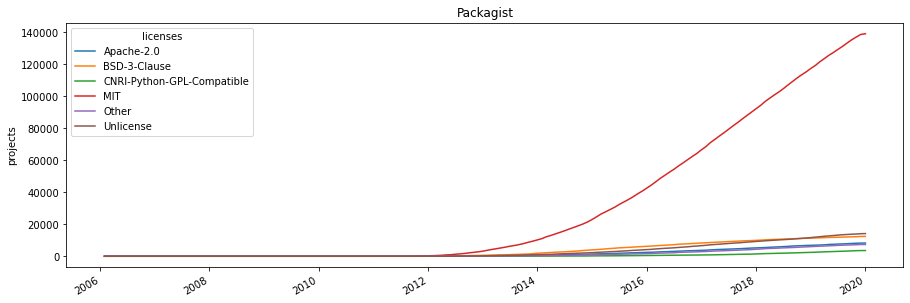

In [12]:
tmp=(packages
 .groupby(['platform','licenses','created'])
 .count()[['name']]
 .reset_index())

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'"')
    liste = df_tmp.groupby(['licenses'])['name'].sum().reset_index().sort_values('name').tail(6).licenses
    df_tmp = df_tmp[df_tmp.licenses.isin(liste)]
    df_tmp = (df_tmp.pivot(index='created', columns='licenses', values='name').fillna(0)
                   .reset_index().sort_values('created'))
    
    for c in df_tmp.columns[1:]:
        df_tmp[c] = df_tmp[c].cumsum()
    
    ax = df_tmp.plot(x='created',)
    ax.set_ylabel('projects')
    ax.set_xlabel('')
    ax.set_title(platform)
    ax.figure.set_size_inches(15,5)

# Distribution of runtime dependencies amount

platform
NPM          3.742039
Packagist    2.217705
Rubygems     1.690748
Name: direct_dependencies, dtype: float64

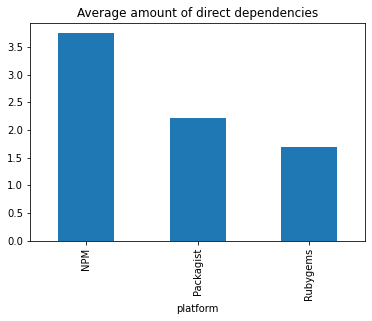

In [13]:
avg_dependencies = packages.groupby('platform').direct_dependencies.mean()
avg_dependencies.plot.bar(title="Average amount of direct dependencies")
avg_dependencies



Statistics for NPM
MIN = 0
Q1 = 0.0
Median = 1.0
Q3 = 4.0
MAX = 1985


Statistics for Rubygems
MIN = 0
Q1 = 0.0
Median = 1.0
Q3 = 2.0
MAX = 222


Statistics for Packagist
MIN = 0
Q1 = 0.0
Median = 1.0
Q3 = 3.0
MAX = 340


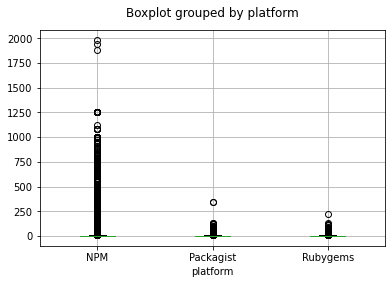

In [14]:
boxplot = packages.boxplot(column='direct_dependencies', by='platform')
boxplot.set_title('')
for platform in platforms:
    print('\n')
    print(f'Statistics for {platform}')
    minv = packages.query(f'platform == "{platform}"')['direct_dependencies'].min()
    maxv = packages.query(f'platform == "{platform}"')['direct_dependencies'].max()
    q = packages.query(f'platform == "{platform}"')['direct_dependencies'].quantile([0.25, 0.5, 0.75])
    print(f'MIN = {minv}')
    print(f'Q1 = {q[0.25]}')
    print(f'Median = {q[0.5]}')
    print(f'Q3 = {q[0.75]}')
    print(f'MAX = {maxv}')

# Most common license pairs in each ecosystem
Format = derrivative's license + used package's license

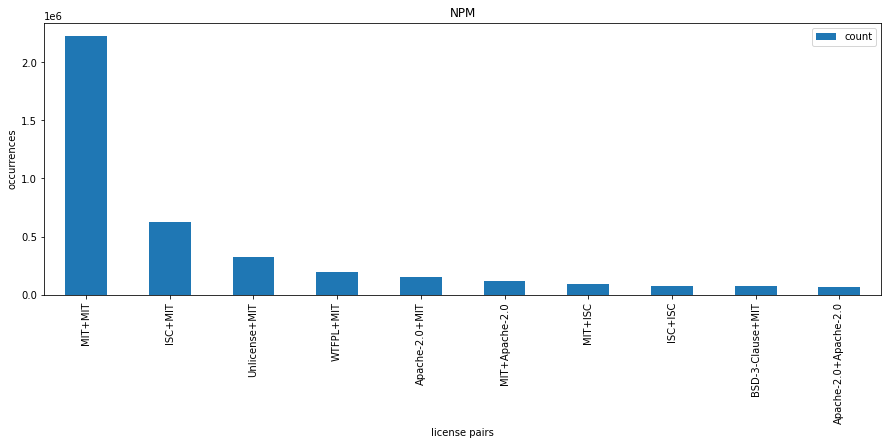

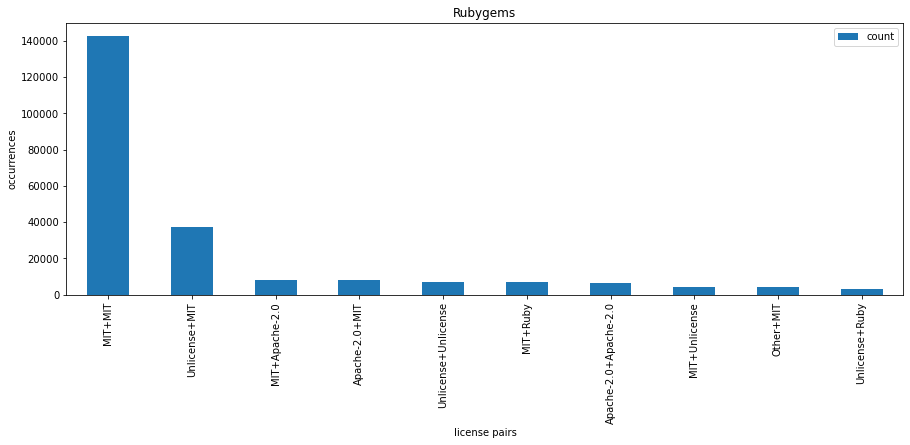

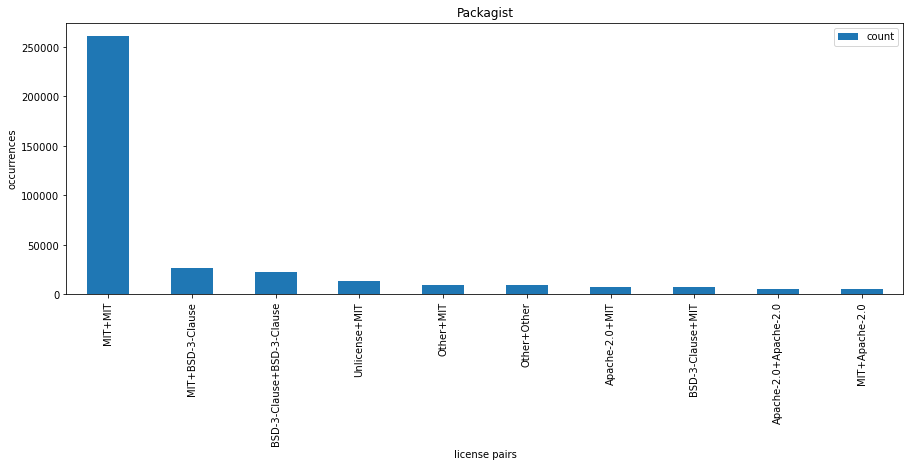

In [15]:
tmp = (deps.groupby(['platform', 'licenses', 'dep_licenses'])
       .size()
       .reset_index()
       .rename(columns={0:'count'})
       .sort_values(by='count', ascending=False))

tmp['pairname'] = tmp['licenses']+"+"+tmp['dep_licenses']

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'"').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(platform)
    chart.figure.set_size_inches(15,5)



# Most common illegal license pairs in each ecosystem
Format = derrivative's license + used package's license

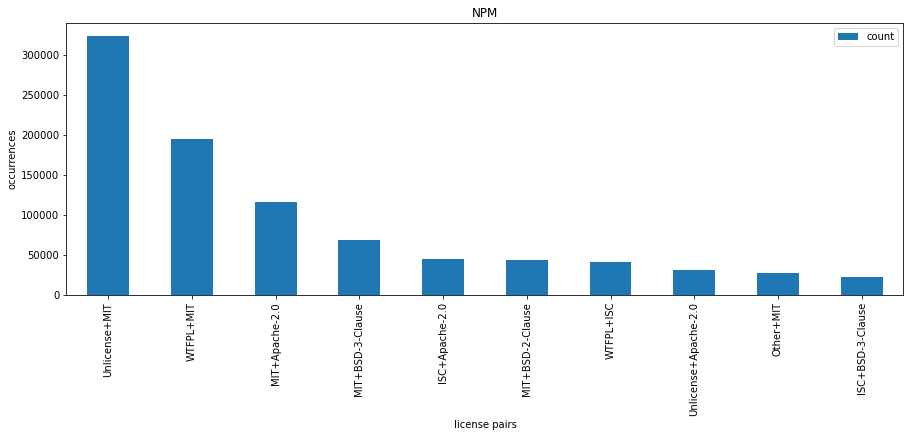

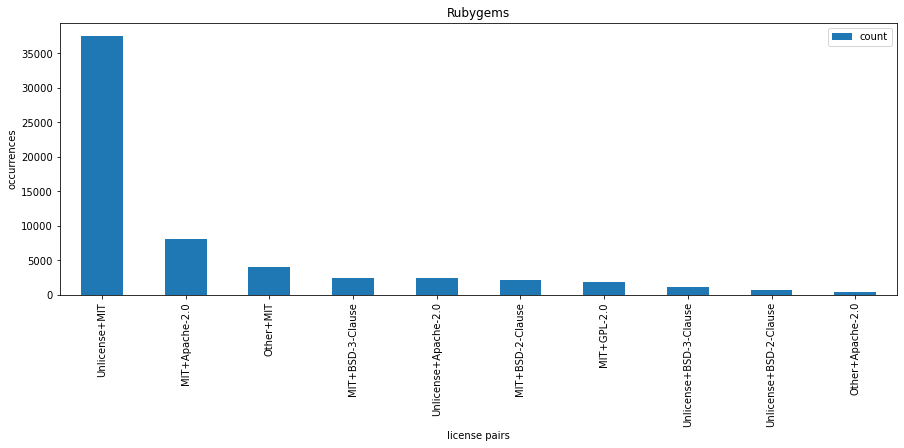

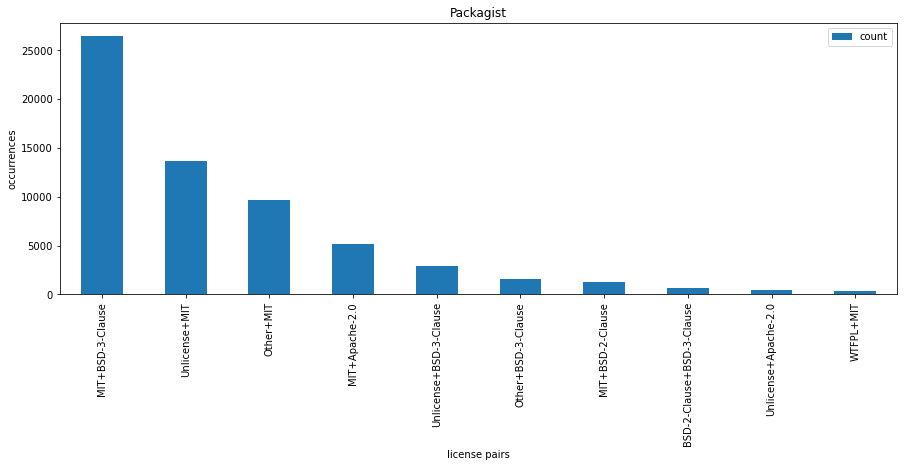

In [16]:
tmp = (deps.groupby(['platform', 'compatible', 'licenses', 'dep_licenses'])
       .size()
       .reset_index()
       .rename(columns={0:'count'})
       .sort_values(by='count', ascending=False))

tmp['pairname'] = tmp['licenses']+"+"+tmp['dep_licenses']

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'" & compatible == False').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(platform)
    chart.figure.set_size_inches(15,5)

# Ecosystems with the most issues

platform
NPM          1019813
Packagist      67351
Rubygems       63633
dtype: int64

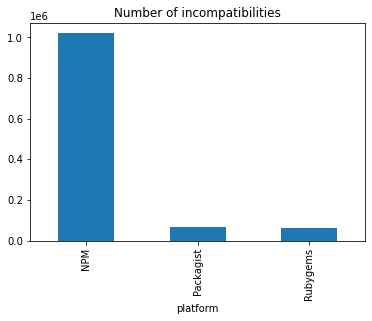

In [17]:
test = deps.query('compatible == False').groupby('platform').size()
test.plot.bar(title="Number of incompatibilities")
test

platform
NPM          21.398883
Packagist    14.568521
Rubygems     23.310670
dtype: float64

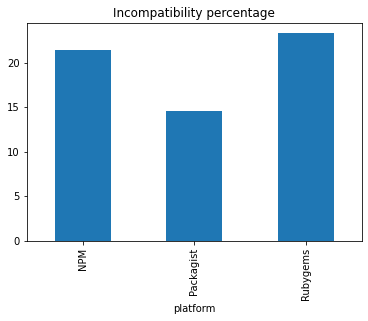

In [18]:
test = deps.query('compatible == False').groupby('platform').size().astype(float)
test["NPM"] = 100*test["NPM"]/amount_of_npm_deps
test["Packagist"] = 100*test["Packagist"]/amount_of_packagist_deps
test["Rubygems"] = 100*test["Rubygems"]/amount_of_rubygems_deps
test.plot.bar(title="Incompatibility percentage")
test

In [19]:
test = deps.query('compatible == False').groupby('platform').size().astype(float)
test

platform
NPM          1019813.0
Packagist      67351.0
Rubygems       63633.0
dtype: float64

In [20]:
(deps[deps.name.isin(deps.dependency)].query('licenses == "ICU" & platform == "NPM"').name.unique().size)

1293

# Some license pairs that have unknown compatibility

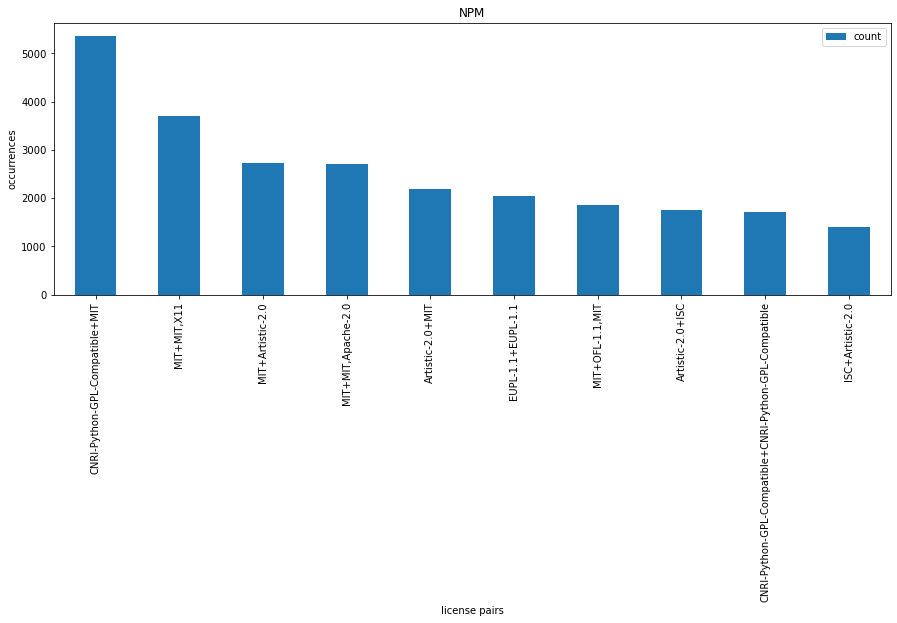

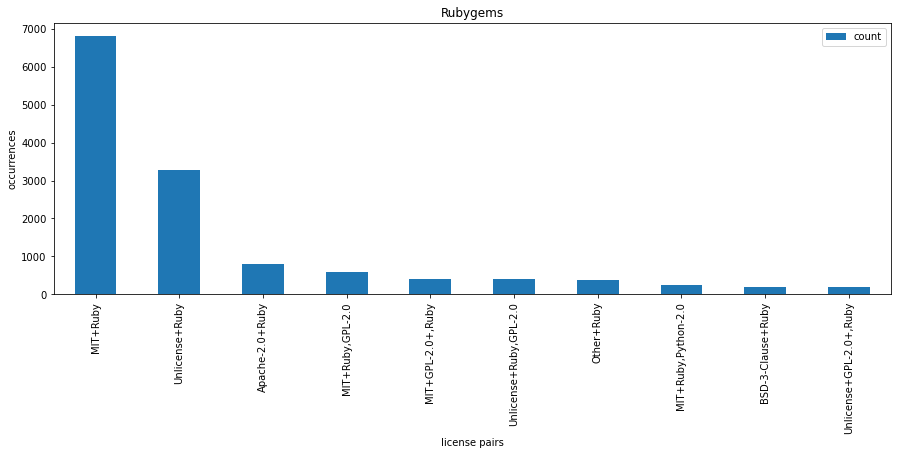

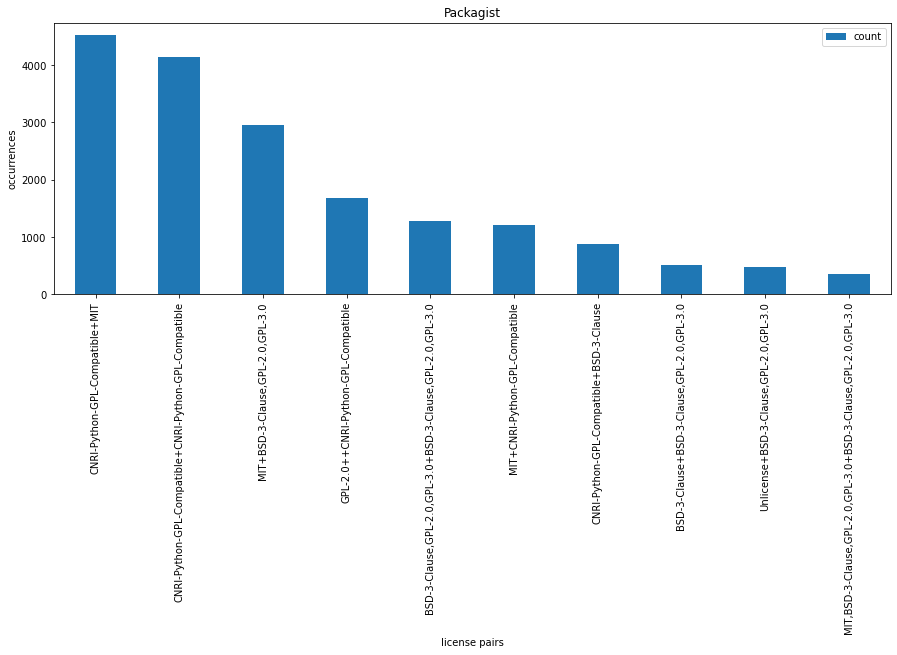

In [21]:
tmp = (deps.groupby(['platform', 'compatible', 'licenses', 'dep_licenses'])
       .size()
       .reset_index()
       .rename(columns={0:'count'})
       .sort_values(by='count', ascending=False))

tmp['pairname'] = tmp['licenses']+"+"+tmp['dep_licenses']

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'" & compatible == "Unknown"').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(platform)
    chart.figure.set_size_inches(15,5)